# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
import networks
from utils import download_model_if_doesnt_exist


## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [3]:
def prepare_image(input_image,  w, h):
    input_image_resized = input_image.resize((w, h), pil.LANCZOS)
    return transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [4]:
def prdict_om_image(input_image_pytorch):
    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    return outputs[("disp", 0)]

## Plotting

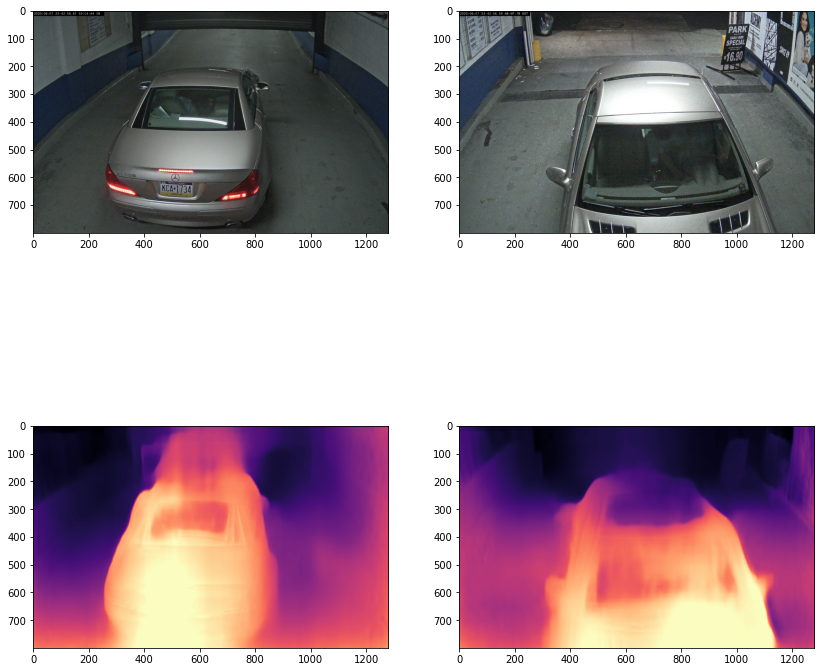

In [5]:
image_path1 = "./data/entry1/1591587776858.jpg"
image_path2 =  "./data/exit1/1591587776850.jpg"

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image1 = pil.open(image_path1).convert('RGB')
input_image2 = pil.open(image_path2).convert('RGB')

image1 = prepare_image(input_image1, feed_width, feed_height)
image2 = prepare_image(input_image2, feed_width, feed_height)

(original_width, original_height) = input_image1.size

disp1 = prdict_om_image(image1)
disp2 = prdict_om_image(image2)

disp_resized1 = torch.nn.functional.interpolate(disp1,
    (original_height, original_width), mode="bilinear", align_corners=False)

disp_resized2 = torch.nn.functional.interpolate(disp2,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np1 = disp_resized1.squeeze().cpu().numpy()
disp_resized_np2 = disp_resized2.squeeze().cpu().numpy()

vmax1 = np.percentile(disp_resized_np1, 95)
vmax2 = np.percentile(disp_resized_np2, 95)

fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(input_image1)
#ax1.title = "Input1"
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(input_image2)
#ax2.title = "Input2"

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(disp_resized_np1, cmap='magma', vmax=vmax1)
#ax3.title = "Disparity prediction1"
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(disp_resized_np2, cmap='magma', vmax=vmax2)
#ax4.title = "Disparity prediction2"


In [8]:
import yolov5
yolo = yolov5.YOLOv5("models/yolov5s.pt", device="cpu")
yolo.device

Adding autoShape... 


'cpu'

In [10]:
results = yolo.predict(input_image1)

In [16]:
results.show()

# Task

Assuming that zones are overlaping use disparsity data and object detection to map those zones and create geometrical transformation that would allow generating expected bounding box on opposite camera. 